ESTO ES PARA EL LST

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon
from matplotlib.tri import Triangulation
from LST import LST
from Node import Node
from solve import Pro_Solver
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace


In [43]:
input_file = "T4.geo"
output_file = "mallas/malla_LST.msh"  
titulo = "Caso LST"

In [44]:
def reorder_triangle6(node_ids, nodes):
    """
    Asegura que los nodos del triángulo de 6 nodos estén en orden:
    [v1, v2, v3, m12, m23, m31]
    según convención FEM (Gmsh puede usar [v1, v2, v3, m23, m31, m12])
    """

    # Coordenadas de los 6 nodos
    coords = np.array([[nodes[nid - 1].x, nodes[nid - 1].y] for nid in node_ids])

    # Los primeros tres son los vértices
    v1, v2, v3 = coords[:3]

    # Los últimos tres son los nodos de borde (midside)
    mids = coords[3:]

    # Función auxiliar: distancia al segmento
    def is_between(p, a, b):
        mid = 0.5 * (a + b)
        return np.linalg.norm(p - mid) < 1e-8  # tolerancia

    # Identifica cuál nodo es m12, m23, m31
    m12 = m23 = m31 = None
    for i, p in enumerate(mids):
        if is_between(p, v1, v2):
            m12 = node_ids[3 + i]
        elif is_between(p, v2, v3):
            m23 = node_ids[3 + i]
        elif is_between(p, v3, v1):
            m31 = node_ids[3 + i]

    if None in (m12, m23, m31):
        print(f"⚠️ Error reordenando nodos LST: {node_ids}")
        return node_ids  # fallback

    # Devuelve orden correcto
    return [node_ids[0], node_ids[1], node_ids[2], m12, m23, m31]


In [45]:
from LST import LST
from Node import Node
# 👇 AQUI MISMO pega esta función:

def fix_LST_order(node_ids, nodes):
    """
    Corrige el orden de los nodos de un triángulo LST para asegurar sentido antihorario.
    Muestra advertencia si se aplica corrección.
    """
    p1 = np.array([nodes[node_ids[0] - 1].x, nodes[node_ids[0] - 1].y])
    p2 = np.array([nodes[node_ids[1] - 1].x, nodes[node_ids[1] - 1].y])
    p3 = np.array([nodes[node_ids[2] - 1].x, nodes[node_ids[2] - 1].y])
    detJ = 0.5 * ((p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1]))

    if detJ <= 0:
        print(f"⚠️ Elemento con nodos {node_ids} tiene det(J) = {detJ:.4e} (corrigiendo orden)")
        return [node_ids[0], node_ids[2], node_ids[1], node_ids[5], node_ids[4], node_ids[3]]
    return node_ids



In [46]:
mesh = meshio.read(output_file)
nodes = [Node(i + 1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

lst_elements = []
for cell_block in mesh.cells:
    if cell_block.type == "triangle6":
        for i, node_ids in enumerate(cell_block.data):
            node_ids = [int(id) + 1 for id in node_ids]  # pasar a base 1
            ordered_ids = reorder_triangle6(node_ids, nodes)
            lst_elements.append(LST(i + 1, ordered_ids))

        break

boundary_nodes = {1: set(), 2: set(), 3: set(), 4: set()}
if "line3" in mesh.cell_data_dict["gmsh:physical"]:
    for cell_block in mesh.cells:
        if cell_block.type == "line3":
            physical_ids = mesh.cell_data_dict["gmsh:physical"]["line3"]
            for line, phys_id in zip(cell_block.data, physical_ids):
                if phys_id in boundary_nodes:
                    for node_id in line:
                        boundary_nodes[phys_id].add(int(node_id) + 1)

for node in nodes:
    node.boundary_label = []
    for label_id, node_set in boundary_nodes.items():
        if node.id in node_set:
            node.boundary_label.append("Dirichlet Boundary")

# Verificación visual
print(boundary_nodes)


{1: {1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61}, 2: {2, 3, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118}, 3: {128, 129, 130, 3, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 146, 4, 119, 120, 121, 122, 123, 124, 125, 126, 127}, 4: {1, 4, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [47]:
alpha = 3
for node in nodes:
    node.solve_u(alpha)


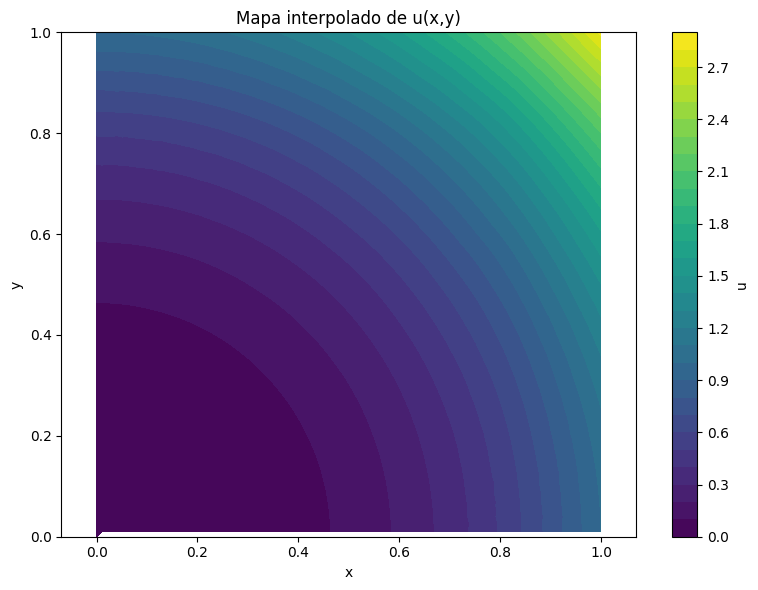

In [48]:
from scipy.interpolate import griddata
def plot_u_field(nodes, elements, use_attr="u", mode="colormap"):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([getattr(node, use_attr) for node in nodes])
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    if mode == "colormap":
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), z, (X, Y), method='cubic')
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='viridis')
        plt.colorbar(label=use_attr)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Mapa interpolado de {use_attr}(x,y)")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig(f"LST_{use_attr}_{mode}_plot.png", dpi=300)
        plt.show()

plot_u_field(nodes, lst_elements, use_attr="u", mode="colormap")

⚠️ Elemento 1 tiene Jacobiano singular o negativo (det = -1.74e-06)
⚠️ Elemento 2 tiene Jacobiano singular o negativo (det = -3.47e-06)
⚠️ Elemento 3 tiene Jacobiano singular o negativo (det = -8.67e-07)
⚠️ Elemento 4 tiene Jacobiano singular o negativo (det = -4.34e-06)
⚠️ Elemento 6 tiene Jacobiano singular o negativo (det = -5.65e-06)
⚠️ Elemento 8 tiene Jacobiano singular o negativo (det = -7.60e-06)
⚠️ Elemento 10 tiene Jacobiano singular o negativo (det = -1.05e-05)
⚠️ Elemento 12 tiene Jacobiano singular o negativo (det = -1.49e-05)
⚠️ Elemento 14 tiene Jacobiano singular o negativo (det = -2.15e-05)
⚠️ Elemento 16 tiene Jacobiano singular o negativo (det = -3.14e-05)
⚠️ Elemento 18 tiene Jacobiano singular o negativo (det = -4.63e-05)
⚠️ Elemento 20 tiene Jacobiano singular o negativo (det = -6.85e-05)
⚠️ Elemento 22 tiene Jacobiano singular o negativo (det = -1.02e-04)
⚠️ Elemento 24 tiene Jacobiano singular o negativo (det = -1.52e-04)
⚠️ Elemento 26 tiene Jacobiano singular 

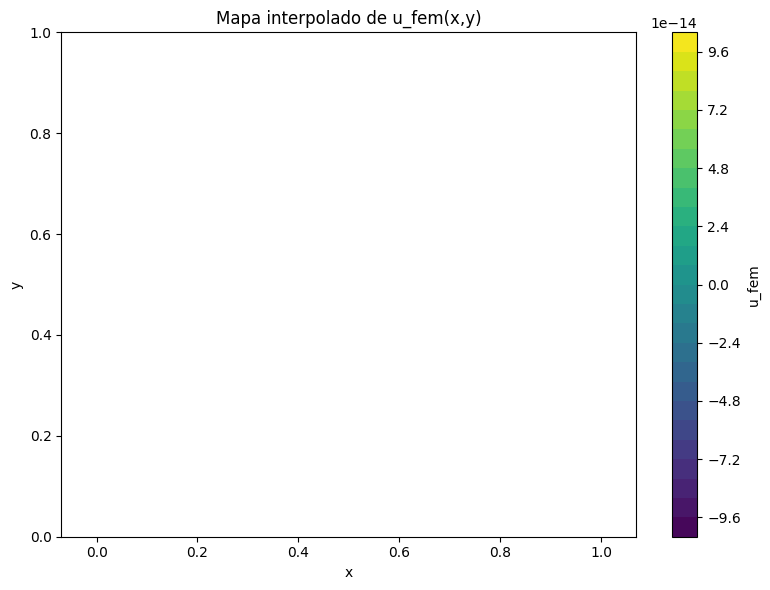

In [49]:
# Resolución FEM
Estructure = Pro_Solver(nodes, lst_elements, alpha)
Estructure.solve_system()

# Gráfico FEM
plot_u_field(nodes, lst_elements, use_attr="u_fem", mode="colormap")

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation
from scipy.interpolate import griddata

def plot_relative_error(nodes, elements, mode="colormap"):
    """
    Visualiza el error relativo |u_fem - u| / |u| mediante:
    - 'colormap' → mapa de color interpolado en 2D
    """
    # Extraer datos de nodos
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    # Evitar división por cero
    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Conectividad de elementos
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    #tri = Triangulation(x, y, triangles)

    if mode == "colormap":
        # Interpolación sobre malla regular
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), error_rel, (X, Y), method='cubic')

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='plasma')
        plt.colorbar(label="Error relativo")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Error relativo |u_fem - u| / |u|")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig("LST_relative_error_colormap.png", dpi=300)
        plt.show()

    else:
        raise ValueError("Modo no válido. Usa 'colormap'.")

    # Imprimir resumen numérico
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")

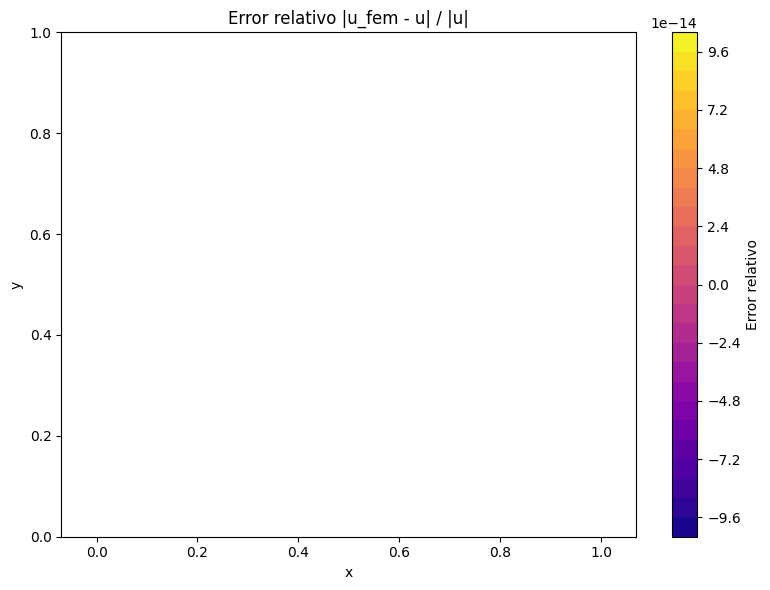

Máximo error relativo: nan
Promedio error relativo: nan
Mínimo error relativo: nan


In [51]:
# Visualizar el error relativo
plot_relative_error(nodes, lst_elements, mode="colormap")